# **`Loan AI`**
In this project, I create a model that can analyze a bank's customer details and ascertain the likelihood of the customer paying back.


#### **Data source:** 
https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset

#### **Procedure:**
1. Preprocessing dataset.
2. Class balancing & outlier handling.
3. Correlation measurement & feature ranking.
4. Tree model development and evaluation.
    - Random Forest
    - XGBoost

# **`Stage 1: Preprocessing`**
### (a) Import libraries | Load dataset

In [39]:
'''General'''
import warnings
warnings.filterwarnings('ignore')

'''Numerical computation'''
import numpy as np
import pandas as pd
# import polars as pl
from scipy.stats import chi2_contingency


''' Visualization '''
import matplotlib.pyplot as plt
import seaborn as sns


'''Encoding & Scaling'''
from sklearn.preprocessing import LabelEncoder, StandardScaler


''' Balancing '''
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE
from sklearn.utils import resample


'''Handling Outliers'''
from scipy.stats import zscore
from scipy.stats import boxcox


'''Test-train split'''
from sklearn.model_selection import train_test_split


''' Metrics '''
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve, auc,
)


from sklearn.model_selection import train_test_split

'''Models'''
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn import tree
from sklearn.linear_model import LogisticRegression


'''XAI'''
import shap
from lime.lime_tabular import LimeTabularExplainer

'''Model export'''
import joblib


'''Libraries Imported'''

'Libraries Imported'

In [44]:
df = pd.read_csv('train-data/heart.csv')

df.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0


In [45]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [46]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### Correlation heatmap
Highly inter-correlated features can increase the overfitting, but that may not be the case always, so we will check for both the scenarios!

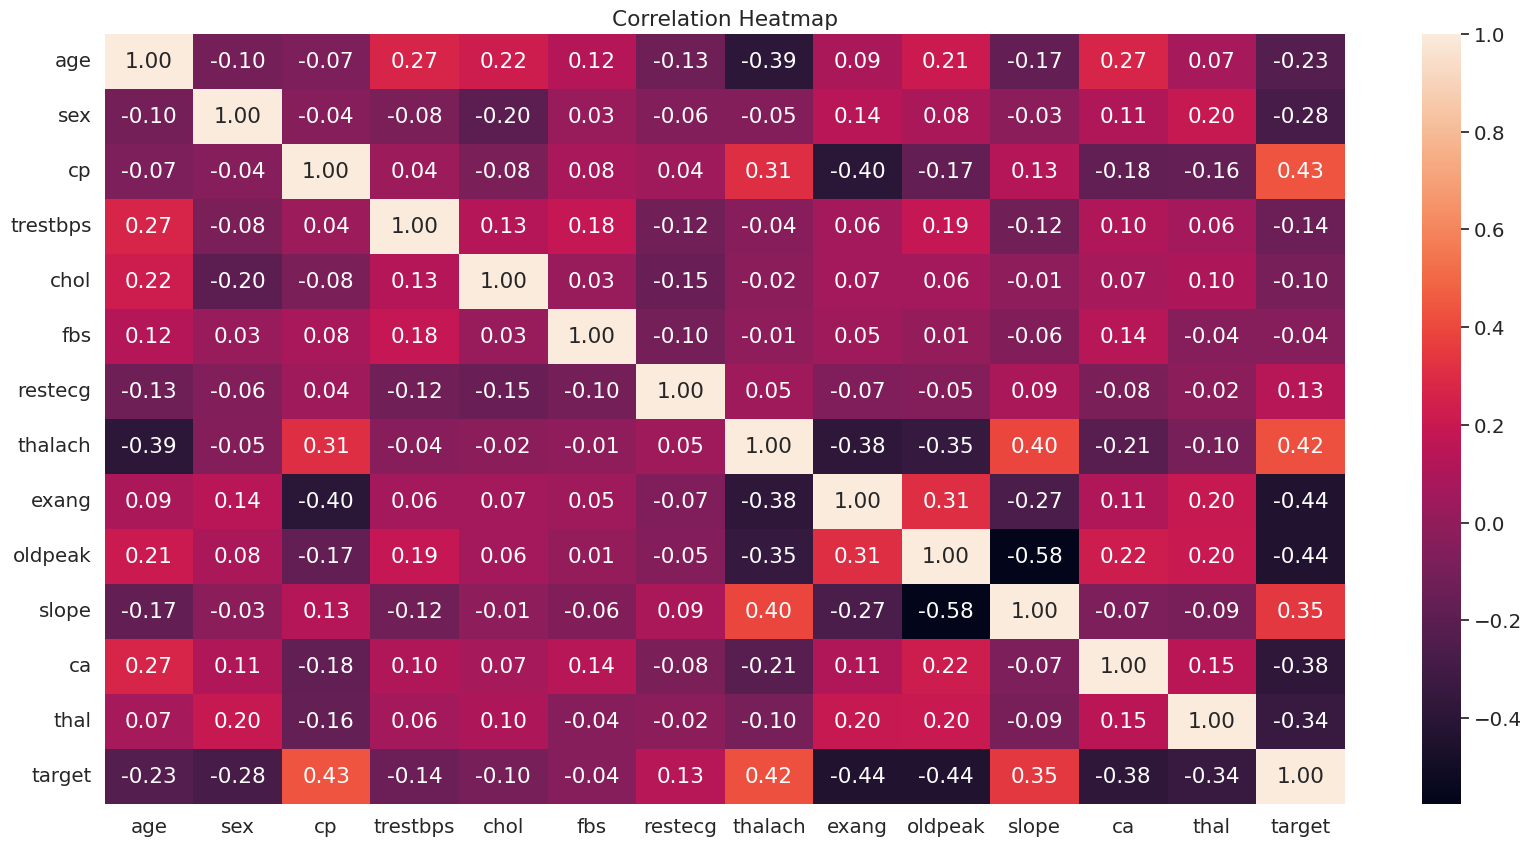

In [47]:
corr_matrix = df.corr()
plt.figure(figsize = (20, 10))
sns.heatmap(corr_matrix, annot = True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# `Balance classes & handle outliers`

In [48]:
# Value counts of target feature
df['target'].value_counts()

target
1    526
0    499
Name: count, dtype: int64

In [49]:
df = pd.get_dummies(df, columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'])

### Identify outliers

In [ ]:
# IQR
for col in df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    if not outliers.empty:
        print(f"Outliers detected in {col}:\n{outliers}\n")
    else:
        print(f"No outliers detected in {col}.")

Test-train split

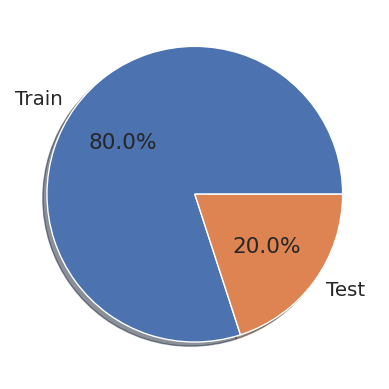

Train set (820, 30)
Test set (205, 30)


In [50]:
features = list(df.columns.drop(['target']))

X = df[features]
Y = df[['target']]
X_train, X_test, y_train , y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

labels = 'Train', 'Test'
plt.pie([80, 20], labels=labels, autopct='%1.1f%%', shadow=True)
plt.show()

print("Train set", X_train.shape)
print("Test set", X_test.shape)

# **`STAGE 4: Model development and evaluation.`**

For each algorithm,
- Split dataset for testing and training
- Visualize confusion matrix of predicted values against actual values
- Evaluate the metrics of each algorithm.

Model functions

In [10]:
def eval_alg(model, X_test, y_test):
    """
        Evaluate a trained model and visualize performance metrics.

        Parameters:
            model: The trained model to evaluate.
            test_x: Test feature set.
            test_y: True labels for the test set.

        Returns:
            accuracy, precision, recall, f1: Calculated metrics.
    """

    # Evaluate on the test set
    y_pred = model.predict(X_test)

    # Calculate and print metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")

    # print(f"\nClassification Report: \n{classification_report(test_y, y_pred)}")

    c_matrix = confusion_matrix(y_test, y_pred)
    matrix_df = pd.DataFrame(c_matrix)

    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.3)
    sns.heatmap(
        matrix_df, annot=True, fmt=".0f", cmap="magma",
        xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"]
    )
    plt.title(f'Confusion Matrix - {type(model).__name__}')
    plt.xlabel("Predicted Label", fontsize=15)
    plt.ylabel("True Label", fontsize=15)
    plt.show()
    # return accuracy, precision, recall, f1

XAI functions

In [24]:
def performLime(model, instance_idx):
    """
        Perform LIME interpretation for a given model and data instance.

        Parameters:
            model: Trained machine learning model to be explained.
            instance_idx: Index of the test instance to interpret.

        Returns:
            None. Displays the explanation and prints feature contributions.
    """
    # Validate instance index
    if instance_idx < 0 or instance_idx >= len(X_test):
        raise ValueError(f"Instance index {instance_idx} is out of bounds.")
    
    # Define class and feature names
    class_names = ['Risk', 'Safe']
    feature_names = list(X_test.columns)

    # Create the LIME explainer
    explainer = LimeTabularExplainer(
        X_train.values,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification',
        kernel_width=3, 
        random_state=42
    )

    # Get the specific instance to explain
    instance = X_test.iloc[instance_idx].values

    # Generate explanation
    explanation = explainer.explain_instance(instance, model.predict_proba)
    
    # Display explanation in a notebook or save to file
    try:
        explanation.show_in_notebook()
    except ImportError:
        explanation.save_to_file(f"lime_explanation_instance_{instance_idx}.html")
        print(f"Explanation saved to lime_explanation_instance_{instance_idx}.html")

    print(f"\nExplanation for instance {instance_idx}:")
    for feature, weight in explanation.as_list():
        print(f"{feature}: {weight:.4f}")

    actual_label = y_test.iloc[instance_idx]
    decoded_label = class_names[actual_label]

    print(f"\nActual target value for instance {instance_idx}: {actual_label} ({decoded_label})")


def performShap(model):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)

    try:
        shap.plots.bar(shap_values)
    except IndexError:
        shap_values_class_1 = shap_values[:, :, 1]
        shap.plots.bar(shap_values_class_1)

shap.initjs()

## `Random Forest`
An ensemble of multiple decision trees on random subsets of the training data. Each tree uses the Gini impurity criterion to select the best feature for splitting at each node. The predictions from all trees are combined to produce the final output.


### Reason for choice:
- Randomization: RandomForest introduces randomness in selecting features and training data for each tree, which helps reduce overfitting.
- Combining Predictions: RandomForest combines predictions from multiple trees, hence educes overfitting by averaging the predictions.

In [53]:
ensemble_classifier = RandomForestClassifier(
    criterion='gini',
    n_estimators=1000, 
    max_samples=150,
    random_state=42
)
ensemble_classifier.fit(X_train, y_train)

# Evaluate on the training set
y_train_pred = ensemble_classifier.predict(X_train)
print("Training Set Performance:")
print(classification_report(y_train, y_train_pred))

# Evaluate on the test set
y_test_pred = ensemble_classifier.predict(X_test)
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

Training Set Performance:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       401
           1       0.98      0.98      0.98       419

    accuracy                           0.98       820
   macro avg       0.98      0.98      0.98       820
weighted avg       0.98      0.98      0.98       820

Test Set Performance:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        98
           1       0.95      0.98      0.97       107

    accuracy                           0.97       205
   macro avg       0.97      0.97      0.97       205
weighted avg       0.97      0.97      0.97       205



Random Forest Classifier
Accuracy: 0.97
Precision: 0.95
Recall: 0.98
F1-score: 0.97


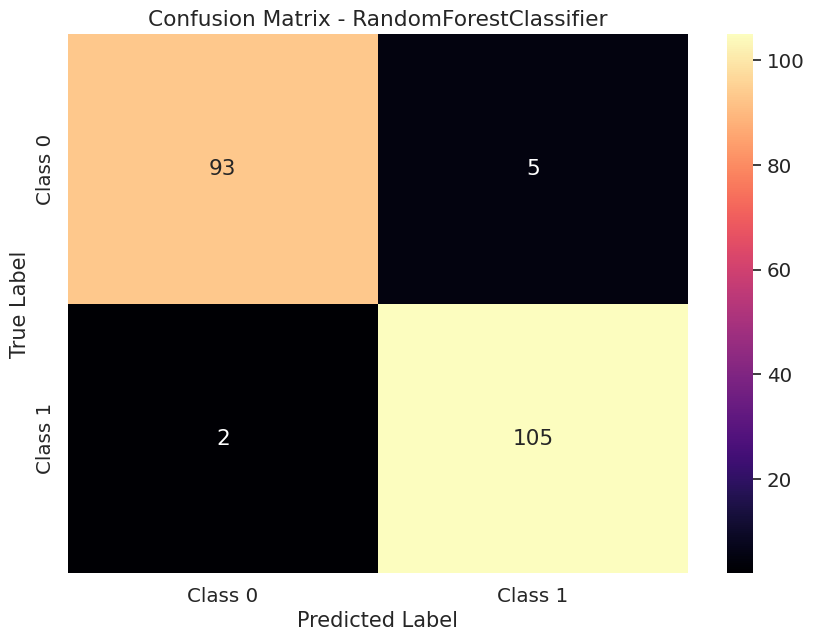

In [54]:
print('Random Forest Classifier')
eval_alg(ensemble_classifier, X_test, y_test)

### Obtaining SHAP values for Random Forest Classifier

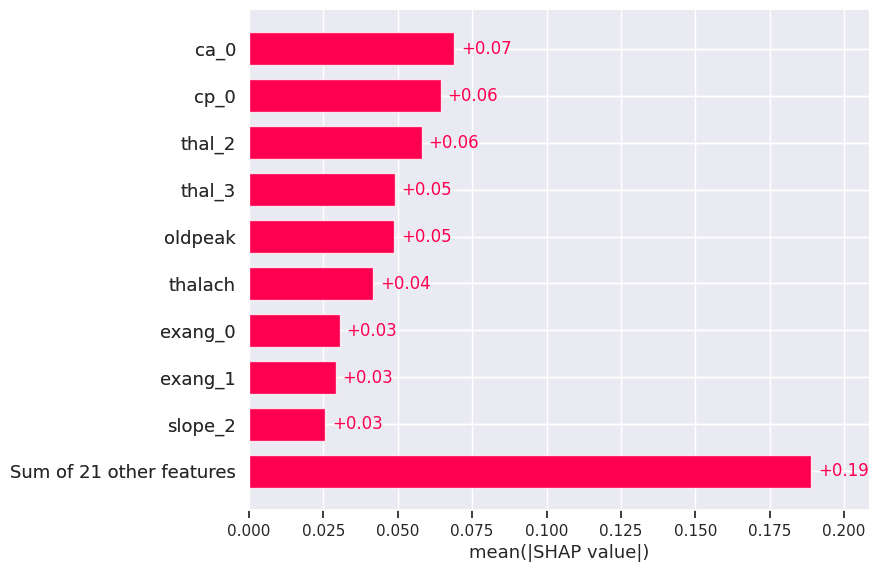

In [55]:
performShap(ensemble_classifier)

In [ ]:
performLime(ensemble_classifier, 0)

Logistic Regressor
Accuracy: 0.90
Precision: 0.88
Recall: 0.93
F1-score: 0.90


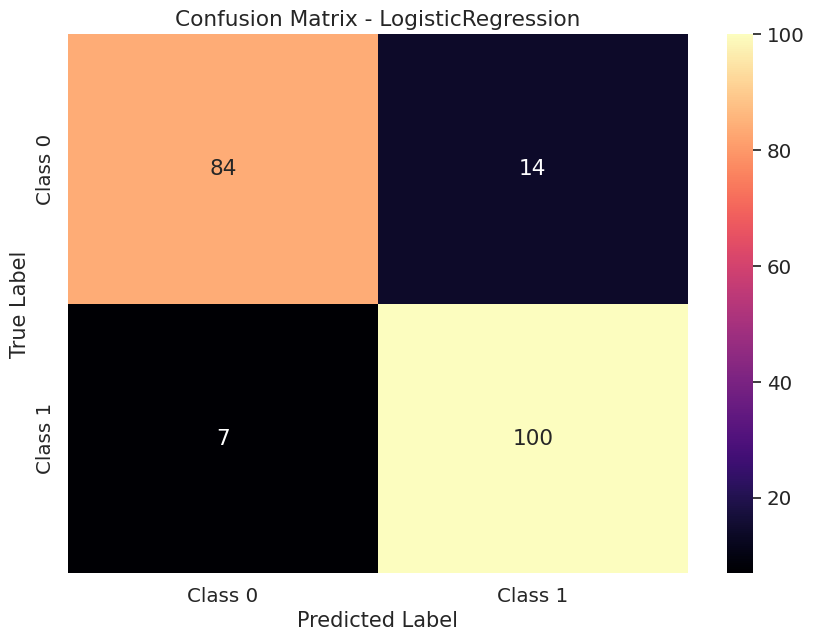

In [56]:
lr_classifier = LogisticRegression(random_state=0)
lr_classifier.fit(X_train, y_train)

print('Logistic Regressor')
eval_alg(lr_classifier, X_test, y_test)

Decision Tree
Accuracy: 0.91
Precision: 0.89
Recall: 0.94
F1-score: 0.92


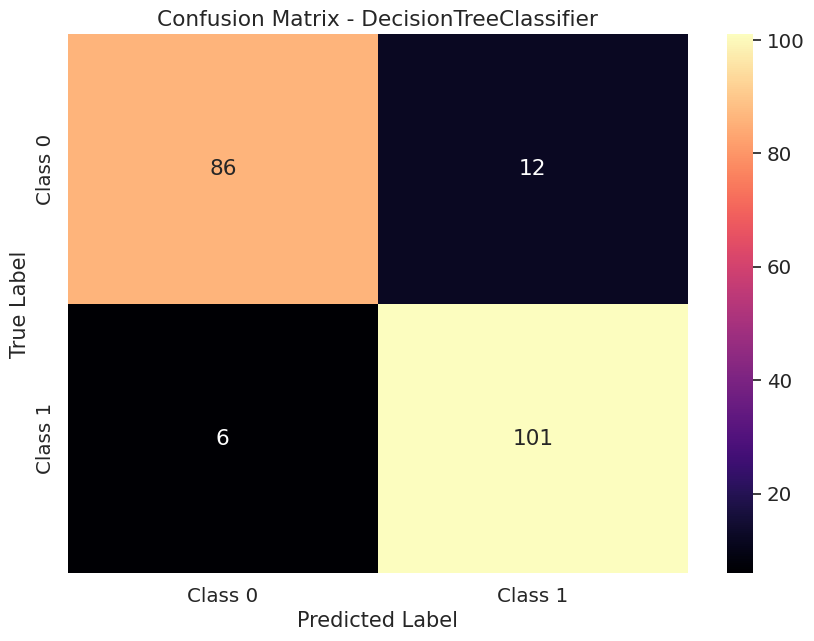

In [57]:
treee = tree.DecisionTreeClassifier(
    criterion = 'entropy',
    random_state=0,
    max_depth = 6
)
treee.fit(X_train, y_train)

print('Decision Tree')
eval_alg(treee, X_test, y_test)

## Pickling models

In [59]:
joblib.dump(ensemble_classifier, 'models/ensembleModel.pkl')
joblib.dump(treee, 'models/treeModel.pkl')
joblib.dump(lr_classifier, 'models/lr_classifier.pkl')


'''Models dumped'''

'Models dumped'

In [60]:
df.columns

Index(['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'target', 'sex_0',
       'sex_1', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'fbs_0', 'fbs_1', 'restecg_0',
       'restecg_1', 'restecg_2', 'exang_0', 'exang_1', 'slope_0', 'slope_1',
       'slope_2', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'thal_0', 'thal_1',
       'thal_2', 'thal_3'],
      dtype='object')

## Load models

In [133]:
jl_ensemble_model = joblib.load('models/ensemble_model.pkl')
jl_ensemble_model_y_pred = jl_ensemble_model.predict(test_x)

In [ ]:
accuracy = accuracy_score(jl_ensemble_model_y_pred, test_y)
c_matrix = metrics.confusion_matrix(jl_ensemble_model_y_pred, test_y)
c_report = classification_report(jl_ensemble_model_y_pred, test_y)

print("Ensemble Accuracy:", accuracy)
print(f"\nClassification Report: \n{c_report}")

In [135]:
jl_xg_model = joblib.load('xg_boost.pkl')
jl_xg_model_y_pred = jl_xg_model.predict(test_x)

In [ ]:
accuracy = accuracy_score(jl_xg_model_y_pred, test_y)
c_matrix = metrics.confusion_matrix(jl_xg_model_y_pred, test_y)
c_report = classification_report(jl_xg_model_y_pred, test_y)

print("XG Accuracy:", accuracy)
print(f"\nClassification Report: \n{c_report}")

## Test

In [137]:
new_df = pd.read_csv('input-data/dataset1.csv')
new_df

,Id,Age,Income,Home,Emp_length,Intent,Amount,Rate,Percent_income,Default,Cred_length
0,13116,23,88000,MORTGAGE,2.0,MEDICAL,6625,11.22,0.08,Y,3


In [138]:
new_df.drop('Id', axis=1, inplace=True)

new_df['Home'] = new_df['Home'].map({
    'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3
})
new_df['Intent'] = new_df['Intent'].map({
    'MEDICAL': 0, 'PERSONAL': 1, 'DEBTCONSOLIDATION': 2, 'HOMEIMPROVEMENT': 3, 'VENTURE': 4, 'EDUCATION': 5
})
new_df['Default'] = new_df['Default'].map({
    'N': 0, 'Y': 1
})

new_df

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Percent_income,Default,Cred_length
0,23,88000,1,2.0,0,6625,11.22,0.08,1,3


In [ ]:
# Predict Status
predicted_Status = jl_ensemble_model.predict(new_df)

# print(f"Predicted Status: {predicted_Status[0]}")
if predicted_Status == 0:
    print(f'Customer unlikely to pay back, predicted with {accuracy} accuracy')

if predicted_Status == 1:
    print(f'Customer likely to pay back, predicted with {accuracy} accuracy')

In [146]:
# Predict PERFORMANCE
predicted_performance = jl_xg_model.predict(new_df)

if predicted_Status == 0:
    print(f'Customer unlikely to pay back, predicted with {accuracy} accuracy')

if predicted_Status == 1:
    print(f'Customer likely to pay back, predicted with {accuracy} accuracy')

Customer unlikely to pay back, predicted with 0.9408020369191598 accuracy


# **`Neural network model development and evaluation`**

### **Pytorch**

Tensorflow

In [ ]:
from sklearn.neural_network import MLPClassifier
import tensorflow as tf


clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2))
clf.fit(X_train, y_train)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1,input_shape=[X_train.shape[1]])]
)
model.summary()

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu',
    input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='mae')

In [ ]:
losses = model.fit(X_train, y_train,
    validation_data=(test_x, test_y),
    batch_size=256,
    epochs=15
)

In [ ]:
loss_df = pd.DataFrame(losses.history)
loss_df.loc[:,['loss','val_loss']].plot()